<a href="https://colab.research.google.com/github/princesingh8178/languagetranslation/blob/main/Language_Transalation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
import zipfile
import pandas as pd

with zipfile.ZipFile('/content/archive (4).zip', 'r') as z:
    print(z.namelist())

    with z.open('deu.txt') as f:
        df = pd.read_csv(f, delimiter='\t', header=None)

df.columns = ['English', 'German', 'Hindi']
df.head()


['_about.txt', 'deu.txt']


,English,German,Hindi
0,Go.,Geh.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Hallo!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Grüß Gott!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run.,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [ ]:
df.drop('German',axis=1,inplace=True)

In [ ]:
df.shape

(221533, 2)

In [ ]:
df.isna().sum()

,0
English,0
Hindi,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df=df.drop_duplicates()

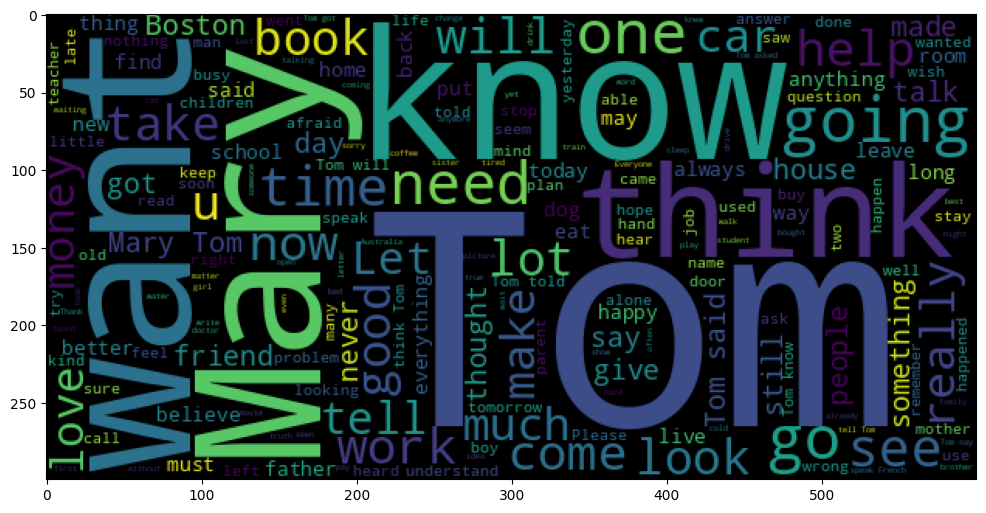

In [ ]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.English))
plt.imshow(wc);

In [ ]:
df['eng_len'] = df.English.apply(len)
df['hi_len'] = df.Hindi.apply(len)

<Axes: xlabel='hi_len', ylabel='Density'>

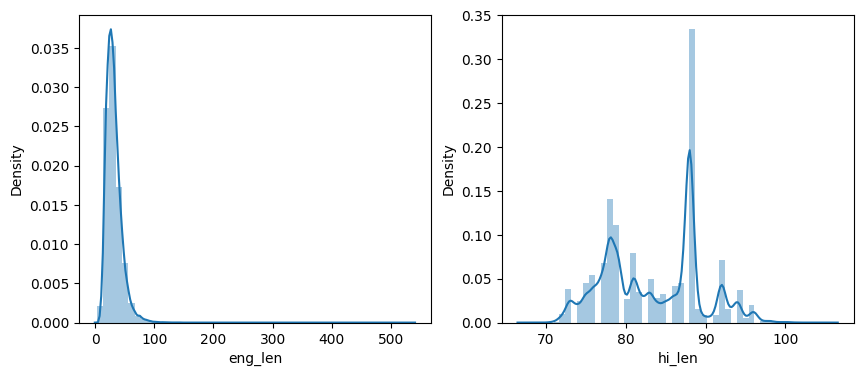

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.distplot(df.eng_len,ax=axes[0])
sns.distplot(df.hi_len,ax=axes[1])

In [ ]:
df.describe()

,eng_len,hi_len
count,221533.000000,221533.000000
mean,31.719974,83.470079
std,13.111863,6.044860
min,3.000000,68.000000
25%,23.000000,78.000000
50%,29.000000,83.000000
75%,38.000000,88.000000
max,537.000000,105.000000


In [ ]:
max_eng_len = 40
max_hi_len = 40

In [ ]:
def clean_text(text):
    text = text.lower()
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text

In [ ]:
df.English = df.English.progress_apply(clean_text)
df.Hindi = df.Hindi.progress_apply(clean_text)

  0%|          | 0/221533 [00:00<?, ?it/s]

  0%|          | 0/221533 [00:00<?, ?it/s]

In [ ]:
df.Hindi = df.Hindi.apply(lambda x: '<START> ' + x + ' <END>')

In [ ]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.English)
eng_tokenizer

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

15928

In [ ]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.English)
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')

In [ ]:
hi_tokenizer = Tokenizer()
hi_tokenizer.fit_on_texts(df.Hindi)

In [ ]:
hi_vocab_size = len(hi_tokenizer.word_index) + 1
hi_vocab_size

381950

In [ ]:
hi_sequences = hi_tokenizer.texts_to_sequences(df.Hindi)
hi_pad_sequences = pad_sequences(hi_sequences,maxlen=max_hi_len,dtype='int32',padding='post',truncating='post')

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)


        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""

            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """

            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """

            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)

            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]


            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]


        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)

        """ Computing energy outputs """

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
K.clear_session()

latent_dim = 300
embedding_dim = 100

encoder_inputs = Input(shape=(max_eng_len,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(hi_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states)

attn_layer = AttentionLayer(name='attention_layer')
attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = TimeDistributed(Dense(hi_vocab_size,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 100)        │      1,592,800 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 40, 300),      │        481,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │     38,195,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 40, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 300),    │        180,300 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 40)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 600)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 381950)   │    229,551,950 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 271,924,850 (1.01 GB)

 Trainable params: 271,924,850 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

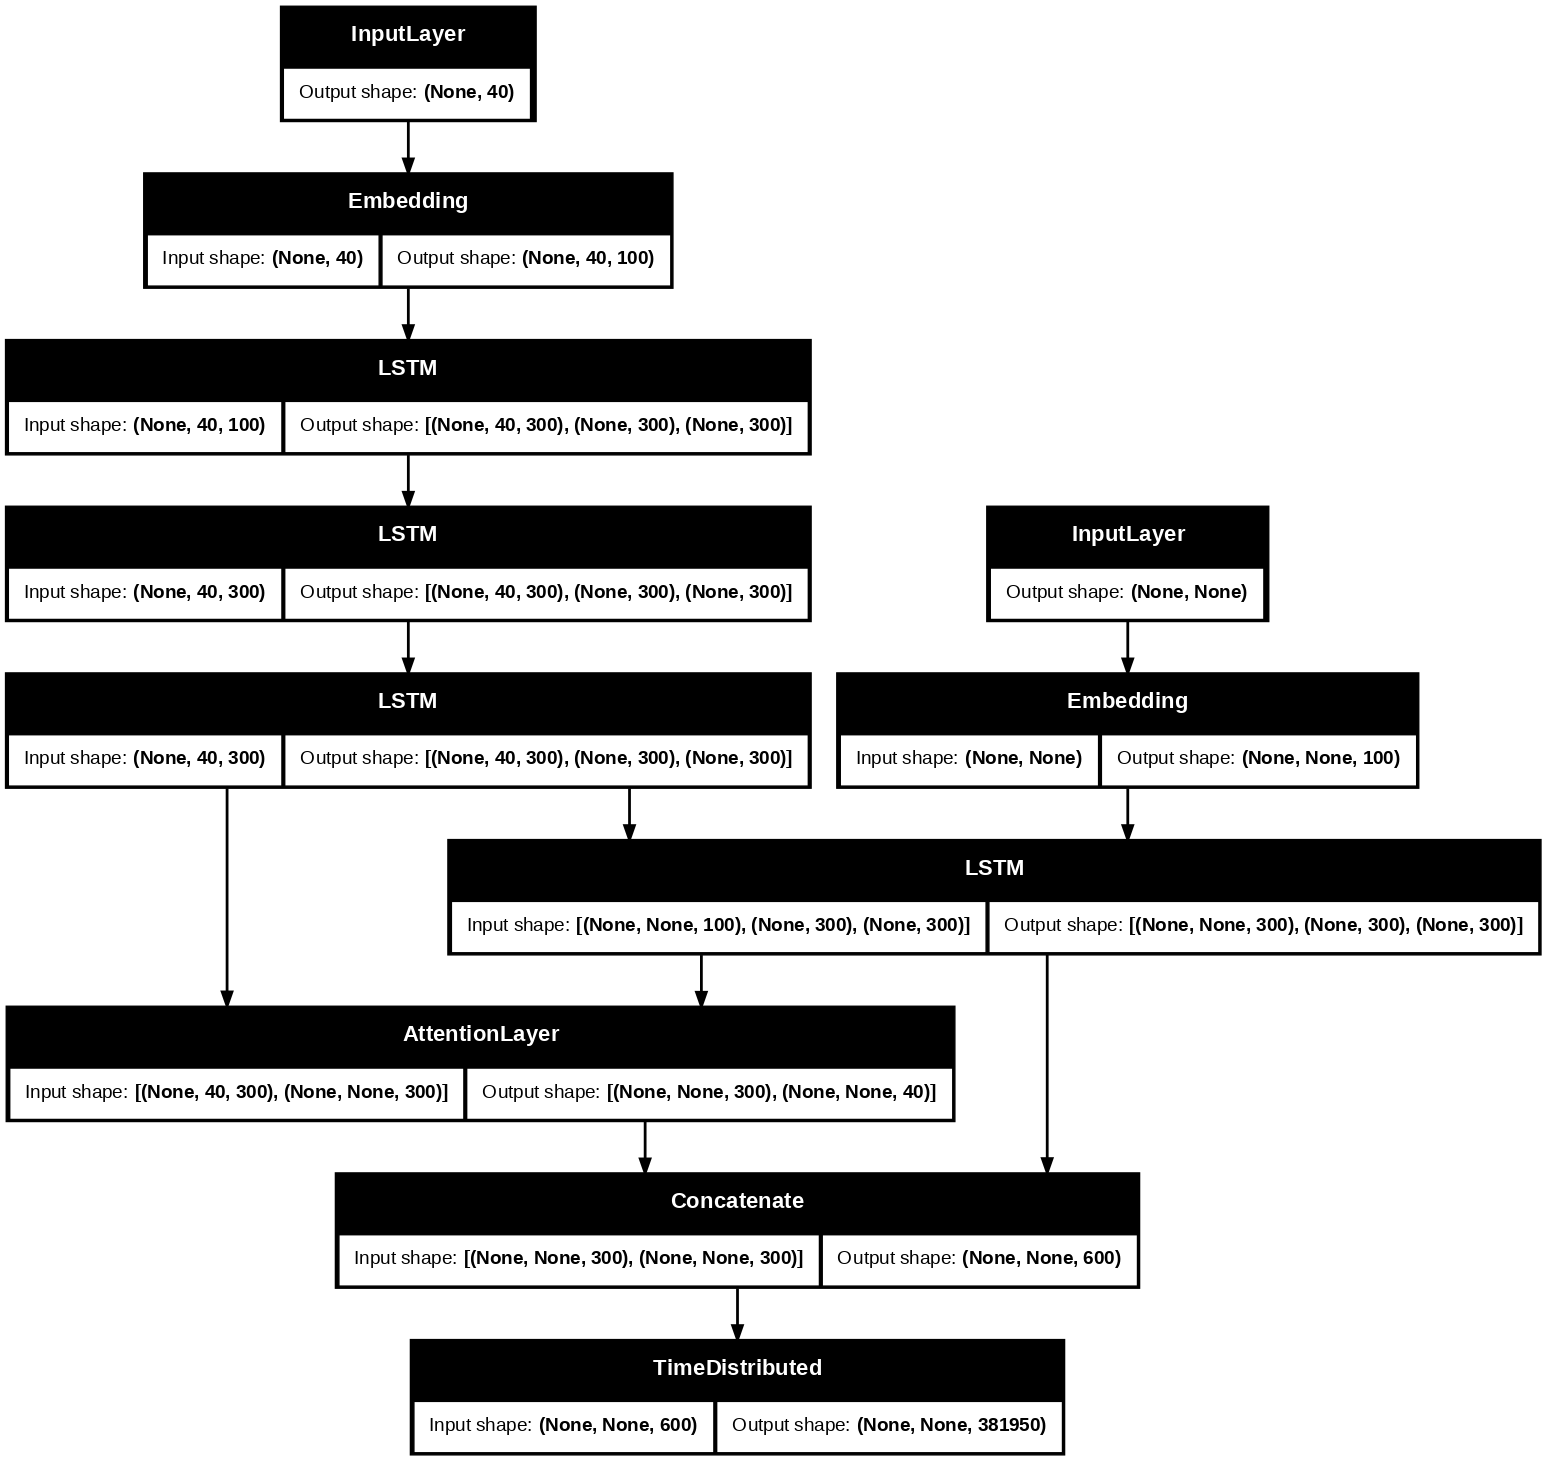

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)


In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,hi_pad_sequences,test_size=0.25,shuffle=True,random_state=101)

X_train shape: (1000, 100, 20, 1)
y_train shape: (1000,)
X_test shape: (1000, 100, 20, 1)
y_test shape: (1000,)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0938 - loss: 2.3406
Epoch 1: val_accuracy improved from -inf to 0.10400, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.0926 - loss: 2.3477 - val_accuracy: 0.1040 - val_loss: 2.3157 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0954 - loss: 2.3246
Epoch 2: val_accuracy improved from 0.10400 to 0.10700, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0952 - loss: 2.3227 - val_accuracy: 0.1070 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0934 - loss: 2.3069
Epoch 3: val_accuracy improved from 0.10700 to 0.10800, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.0932 - loss: 2.3070 - val_

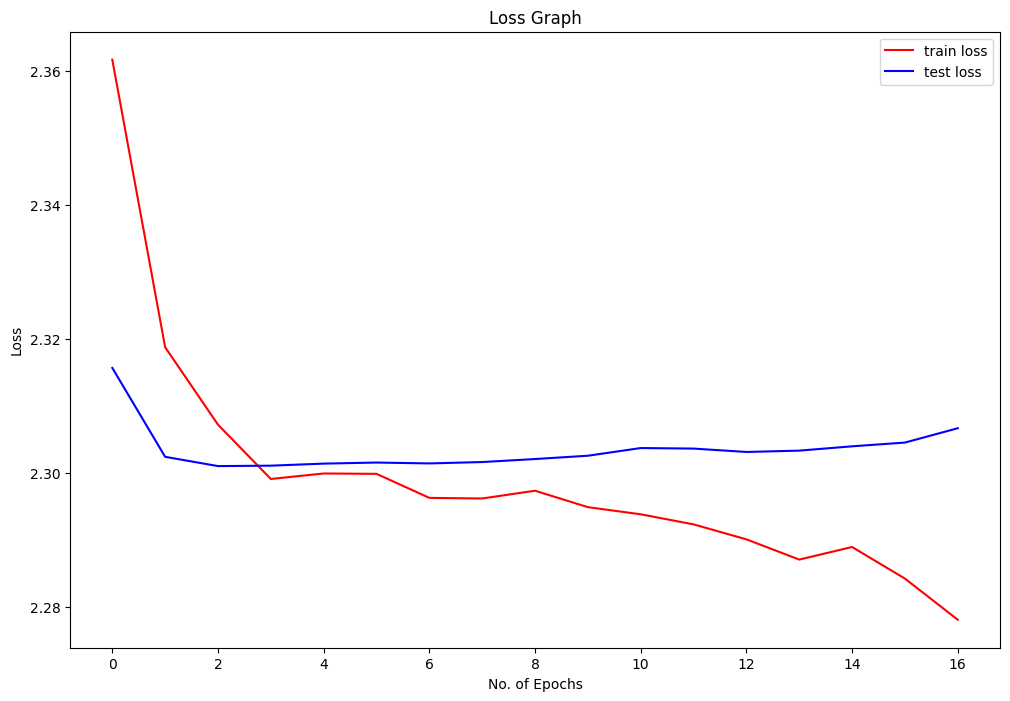

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt


num_samples = 1000
num_frames = 100
num_mfcc_coefficients = 20
num_classes = 10


X_train = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_train = np.random.randint(num_classes, size=num_samples)
X_test = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_test = np.random.randint(num_classes, size=num_samples)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


input_shape = (num_frames, num_mfcc_coefficients, 1)

model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


import os
checkpoint_dir = 'checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
rl = ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1, patience=5, factor=0.1, min_lr=0.001)
mc = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)



r = model.fit(X_train,
              y_train,
              epochs=50,
              batch_size=512,
              callbacks=[es, rl, mc],
              validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


plt.plot(r.history['loss'], 'r', label='train loss')
plt.plot(r.history['val_loss'], 'b', label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


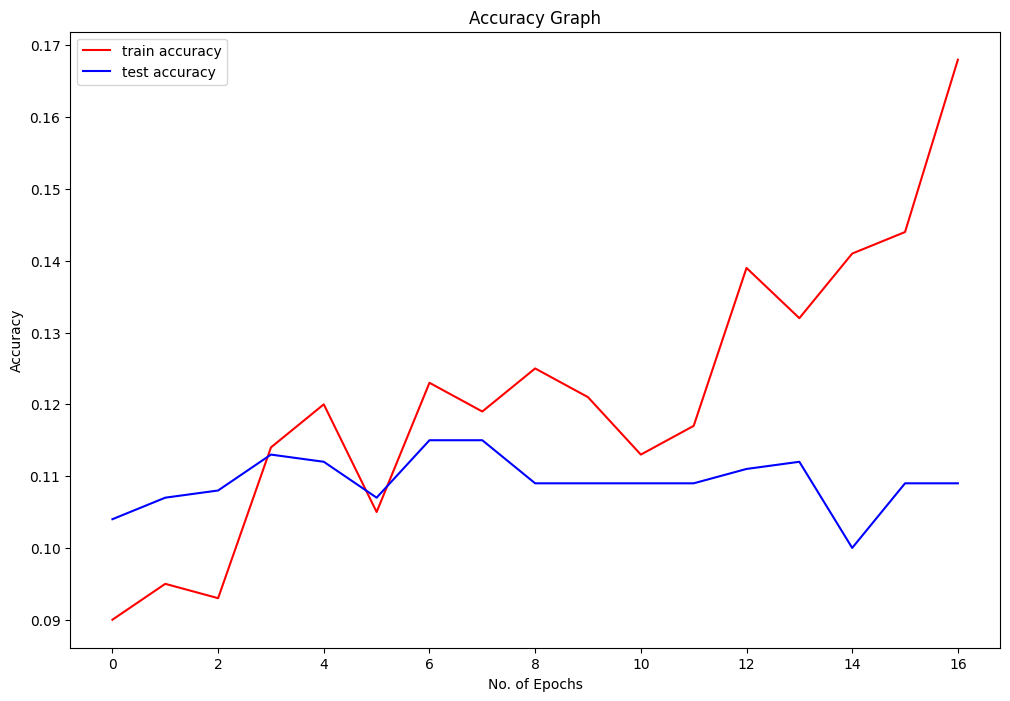

In [ ]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

X_train shape: (1000, 100, 20, 1)
y_train shape: (1000,)
X_test shape: (1000, 100, 20, 1)
y_test shape: (1000,)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1097 - loss: 2.3095
Epoch 1: val_accuracy improved from -inf to 0.10600, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1091 - loss: 2.3095 - val_accuracy: 0.1060 - val_loss: 2.3118 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0954 - loss: 2.3050
Epoch 2: val_accuracy did not improve from 0.10600
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.0966 - loss: 2.3068 - val_accuracy: 0.1060 - val_loss: 2.3110 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1028 - loss: 2.2983
Epoch 3: val_accuracy did not improve from 0.10600
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.1039 - loss: 2.2989 - val_accuracy: 0.1030 - val_loss: 2.3052 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

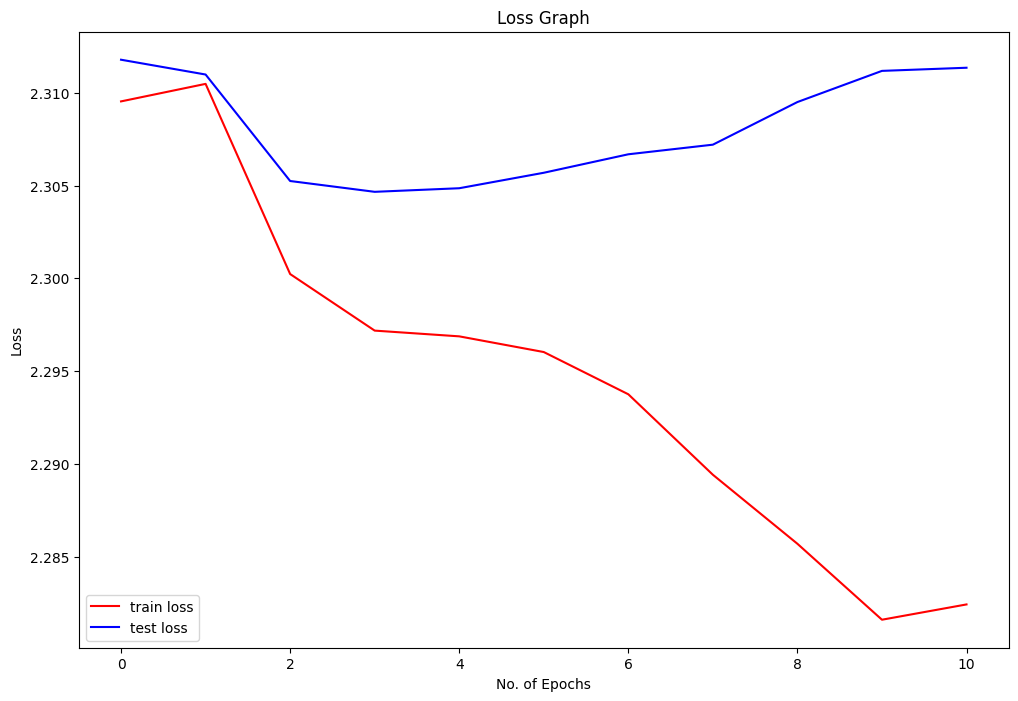

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt

num_samples = 1000
num_frames = 100
num_mfcc_coefficients = 20
num_classes = 10

X_train = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_train = np.random.randint(num_classes, size=num_samples)
X_test = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_test = np.random.randint(num_classes, size=num_samples)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

input_shape = (num_frames, num_mfcc_coefficients, 1)

model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

import os
checkpoint_dir = 'checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
rl = ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1, patience=5, factor=0.1, min_lr=0.001)
mc = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)



r = model.fit(X_train,
              y_train,
              epochs=50,
              batch_size=512,
              callbacks=[es, rl, mc],
              validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


plt.plot(r.history['loss'], 'r', label='train loss')
plt.plot(r.history['val_loss'], 'b', label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


X_train shape: (1000, 100, 20, 1)
y_train shape: (1000,)
X_test shape: (1000, 100, 20, 1)
y_test shape: (1000,)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1131 - loss: 2.3186
Epoch 1: val_accuracy improved from -inf to 0.10300, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1117 - loss: 2.3212 - val_accuracy: 0.1030 - val_loss: 2.3098 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1057 - loss: 2.3261
Epoch 2: val_accuracy improved from 0.10300 to 0.10500, saving model to checkpoint/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.1045 - loss: 2.3248 - val_accuracy: 0.1050 - val_loss: 2.3045 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0934 - loss: 2.3072
Epoch 3: val_accuracy did not improve from 0.10500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0953 - loss: 2.3061 - val_accuracy: 0.0980 - val_loss: 2.3030 - learning_ra

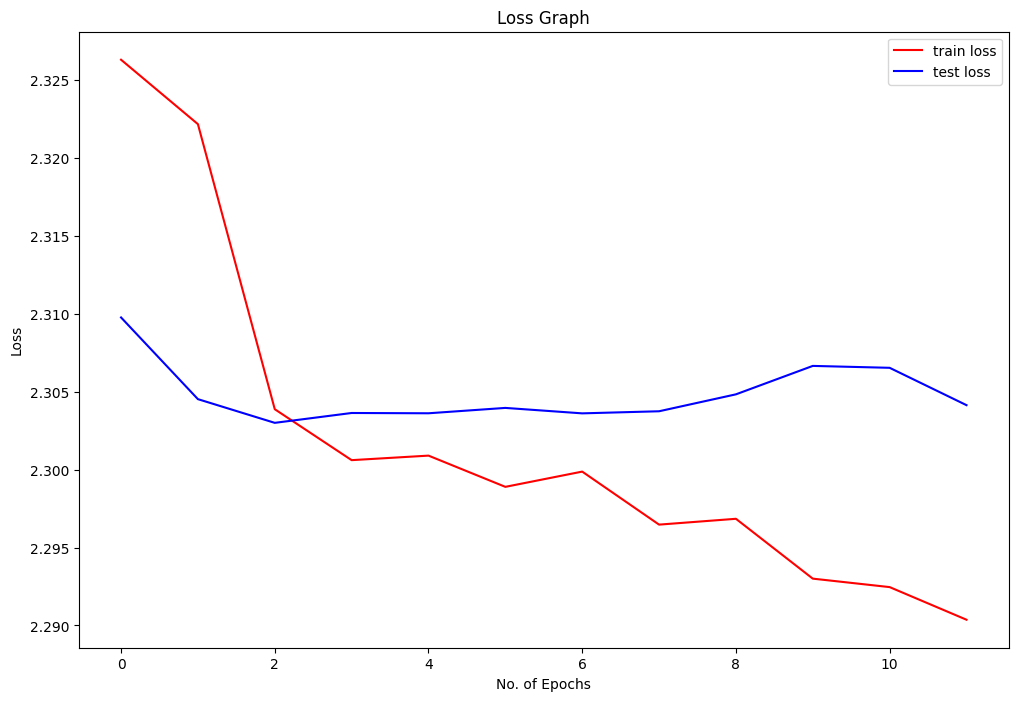

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


num_samples = 1000
num_frames = 100
num_mfcc_coefficients = 20
num_classes = 10

X_train = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_train = np.random.randint(num_classes, size=num_samples)
X_test = np.random.rand(num_samples, num_frames, num_mfcc_coefficients, 1).astype(np.float32)
y_test = np.random.randint(num_classes, size=num_samples)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

input_shape = (num_frames, num_mfcc_coefficients, 1)

model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

import os
checkpoint_dir = 'checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
rl = ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1, patience=5, factor=0.1, min_lr=0.001)
mc = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),  # Updated extension
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

r = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=512,
    callbacks=[es, rl, mc],
    validation_data=(X_test, y_test)
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

model.save('english_to_hindi_translator.keras')


lm = load_model('english_to_hindi_translator.keras')

plt.plot(r.history['loss'], 'r', label='train loss')
plt.plot(r.history['val_loss'], 'b', label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()



In [ ]:
from nltk.translate.bleu_score import sentence_bleu

references = [
    ["यह", "एक", "उदाहरण", "वाक्य", "है"],
    ["दूसरा", "वाक्य", "यहाँ", "है"]

]

predicted_eng_translations = [
    ["This", "is", "an", "example", "sentence"],
    ["Here", "is", "another", "sentence"]

]

for i in range(len(references)):
    print("Original Hindi Sentence:", references[i])
    print("Predicted English Sentence:", predicted_eng_translations[i])
    print("BLEU Score:", sentence_bleu([references[i]], predicted_eng_translations[i], weights=(0.25, 0.25, 0.25, 0.25)))
    print("\n")


Original Hindi Sentence: ['यह', 'एक', 'उदाहरण', 'वाक्य', 'है']
Predicted English Sentence: ['This', 'is', 'an', 'example', 'sentence']
BLEU Score: 0


Original Hindi Sentence: ['दूसरा', 'वाक्य', 'यहाँ', 'है']
Predicted English Sentence: ['Here', 'is', 'another', 'sentence']
BLEU Score: 0


